In [1]:
from retrieve_geo import GeoInfo
import numpy as np
import datetime as dt

%matplotlib inline

### __Specify Test Coordinates and Retrieve Geographic Information__

In [2]:
# x = -2193465
# y = 1885485

x = 1601085
y = 2082225
geo = GeoInfo(x=str(x), y=str(y))

# lat = 40.273651
# lon = -76.871876
# geo = GeoInfo(x=str(lon), y=str(lat), units="geo")
# x = geo.coord.x
# y = geo.coord.y

In [3]:
px = geo.pixel_coord_ul.x
py = geo.pixel_coord_ul.y
px, py

(1601085, 2082225)

In [4]:
x, y

(1601085, 2082225)

## __Use the lcmap-nemo Service to Retrieve PyCCD Segments and Processing Masks__

In [5]:
from nemo_basics import pixels, segments, getsnap, chips
from operator import itemgetter

__getsnap(x, y) will return the chip ulx and uly__

In [6]:
snap = getsnap(x, y)

In [7]:
snap

{'tile': {'proj-pt': [1484415.0, 2114805.0], 'grid-pt': [27.0, 8.0]},
 'chip': {'proj-pt': [1598415.0, 2084805.0], 'grid-pt': [1388.0, 410.0]}}

In [8]:
cx, cy = snap['chip']['proj-pt']
cx, cy

(1598415.0, 2084805.0)

__Use the nemo chips resource to get dates.  chips() returns a list with a single item which is a dict, the 'dates' key contains all of the chip dates__

In [9]:
chip_dates = chips(cx, cy)[0]['dates']

In [10]:
chip_dates[0], chip_dates[-1]

('2017-12-28', '1982-11-18')

__Retrieve the Processing Masks for all Pixels in the Target Chip.  There will be 10000 items in the resulting list from calling pixels(cx, cy).  Use filter() and next() to get the Processing Mask for just the Target Pixel.__

In [11]:
gen = filter(lambda i: i['px'] == px and i['py'] == py, pixels(cx, cy))

target_pixel = next(gen, None)

__Show what kind of information is stored for each pixel__

In [12]:
target_pixel.keys()

dict_keys(['cx', 'cy', 'px', 'py', 'mask'])

__Reference the Processing Mask Directly, but in Reverse so that it matches Chip dates and ARD dates - [::-1] is a scary looking way of reversing a list without altering the list itself__

In [13]:
proc_mask = target_pixel['mask'][::-1]

__Retrieve the Change Model Segments for the Target Pixel within the Returned Chip Results i.e. segments(cx, cy) and Sort the Pixel Segments Based on the 'sday' Values__

In [14]:
segs = sorted([i for i in segments(cx, cy) if i['px'] == px and i['py'] == py], key=itemgetter('sday'))

In [15]:
len(segs)

1

__Display what kind of information is stored for each Pixel__

In [16]:
segs[0].keys()

dict_keys(['thint', 'bday', 'grmag', 'blint', 'grrmse', 's2mag', 'sday', 'grint', 'grcoef', 'px', 'rermse', 's1mag', 'eday', 'nimag', 'thcoef', 'blcoef', 's1rmse', 'nicoef', 's2int', 's2rmse', 'thmag', 'reint', 'cx', 'cy', 's1int', 'blrmse', 'remag', 'thrmse', 's2coef', 'chprob', 'curqa', 'blmag', 'niint', 's1coef', 'py', 'nirmse', 'recoef'])

## __Use lcmap-merlin to Retrieve the ARD Observations for the Target Pixel__

In [17]:
import merlin
import merlin_cfg
from nemo_basics import ard_url

__Generate a configuration that merlin will use to call the lcmap-chipmunk service, currently just requesting ARD for the NIR Surface Reflectance__

In [18]:
cfg = merlin_cfg.make_cfg(['blues', 'greens', 'reds', 'nirs', 'swir1s', 'swir2s', 'thermals'], ard_url)
cfg

{'grid_fn': functools.partial(<function grid at 0x000001F41AE18488>, url='http://lcmap-test.cr.usgs.gov/ARD_CU_C01_V01', resource='/grid'),
 'dates_fn': <function merlin.dates.symmetric(datemap)>,
 'chips_fn': functools.partial(<function chips at 0x000001F41AE18378>, url='http://lcmap-test.cr.usgs.gov/ARD_CU_C01_V01', resource='/chips'),
 'specs_fn': functools.partial(<function mapped at 0x000001F41AE26B70>, ubids={'blues': ['LC08_SRB2', 'LE07_SRB1', 'LT05_SRB1', 'LT04_SRB1'], 'greens': ['LC08_SRB3', 'LE07_SRB2', 'LT05_SRB2', 'LT04_SRB2'], 'reds': ['LC08_SRB4', 'LE07_SRB3', 'LT05_SRB3', 'LT04_SRB3'], 'nirs': ['LC08_SRB5', 'LE07_SRB4', 'LT05_SRB4', 'LT04_SRB4'], 'swir1s': ['LC08_SRB6', 'LE07_SRB5', 'LT05_SRB5', 'LT04_SRB5'], 'swir2s': ['LC08_SRB7', 'LE07_SRB7', 'LT05_SRB7', 'LT04_SRB7'], 'thermals': ['LC08_BTB10', 'LE07_BTB6', 'LT05_BTB6', 'LT04_BTB6']}),
 'format_fn': <function merlin.formats.pyccd(x, y, locations, dates_fn, specmap, chipmap)>,
 'registry_fn': functools.partial(<functi

__We can use the segs to determine the acquisition date range of ARD to Request__

In [19]:
acquired = chip_dates[-1], chip_dates[0]
acquired

('1982-11-18', '2017-12-28')

__We will need a list of ordinal dates for plotting model curves later, so here we convert the strings to ordinal time integer values and create the list of dates.__

In [20]:
seg_params = segs[0]['sday'], segs[0]['eday'], segs[0]['bday']

In [21]:
sday, eday, bday = (dt.datetime.strptime(seg_params[0], '%Y-%m-%d').toordinal(), 
                    dt.datetime.strptime(seg_params[1], '%Y-%m-%d').toordinal(),
                    dt.datetime.strptime(seg_params[2], '%Y-%m-%d').toordinal())

sday, eday, bday

(724378, 736603, 736603)

In [22]:
days = np.arange(sday, bday + 1)
days[:10]

array([724378, 724379, 724380, 724381, 724382, 724383, 724384, 724385,
       724386, 724387])

__Request the Timeseries ARD for the given acquisition period.  merlin.create() returns the ARD for the entire Chip so we use filter() and next() to retrieve just the target pixel ARD.__

In [23]:
gen = filter(lambda x: x[0][2] == px and x[0][3] == py, 
             merlin.create(x, y, acquired=f'{acquired[0]}/{acquired[1]}', cfg=cfg))

seg_ard = next(gen, None)

In [24]:
bands = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'thermal']
# # Only working with NIR band right now
# bands = ['nir']

# dict that organizes pyccd results for each individual band
# band_info = {b: {'coefs': [], 'inter': [], 'pred': []} for b in bands}

In [25]:
def rescale_thermal(thermals):
    """
    Fix the scaling of the Brightness Temperature

    """
    temp_thermal = np.copy(thermals)
    
    fill_mask = temp_thermal != -9999

    temp_thermal[fill_mask] = temp_thermal[fill_mask] * 10 - 27315

    return temp_thermal

In [26]:
seg_ard[1]['thermals'] = rescale_thermal(seg_ard[1]['thermals'])

In [27]:
key_lookup = {'blue': {'coefs': 'blcoef',
                       'inter': 'blint'},
              'green': {'coefs': 'grcoef',
                        'inter': 'grint'},
              'red': {'coefs': 'recoef',
                      'inter': 'reint'},
              'nir': {'coefs': 'nicoef',
                      'inter': 'niint'},
              'swir1': {'coefs': 's1coef',
                        'inter': 's1int'},
              'swir2': {'coefs': 's2coef',
                        'inter': 's2int'},
              'thermal': {'coefs': 'thcoef',
                          'inter': 'thint'}
             }

__Define a Function to Calculate Curve Values for a Change Model Over a Specified Sequence of Days__

In [28]:
def predicts(days, coef, intercept):
    return (intercept + coef[0] * days +
            coef[1]*np.cos(days*1*2*np.pi/365.25) + coef[2]*np.sin(days*1*2*np.pi/365.25) +
            coef[3]*np.cos(days*2*2*np.pi/365.25) + coef[4]*np.sin(days*2*2*np.pi/365.25) +
            coef[5]*np.cos(days*3*2*np.pi/365.25) + coef[6]*np.sin(days*3*2*np.pi/365.25))

In [29]:
curves = {band: predicts(days, 
                         segs[0][key_lookup[band]['coefs']],
                         segs[0][key_lookup[band]['inter']]) for band in bands}

__Confirm that the number of curve values generated is equal to the number of dates__

In [30]:
for b in bands:
    assert len(curves[b] == len(days))

In [31]:
len(days)

12226

## __Plot the Change Model Curve__

In [32]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

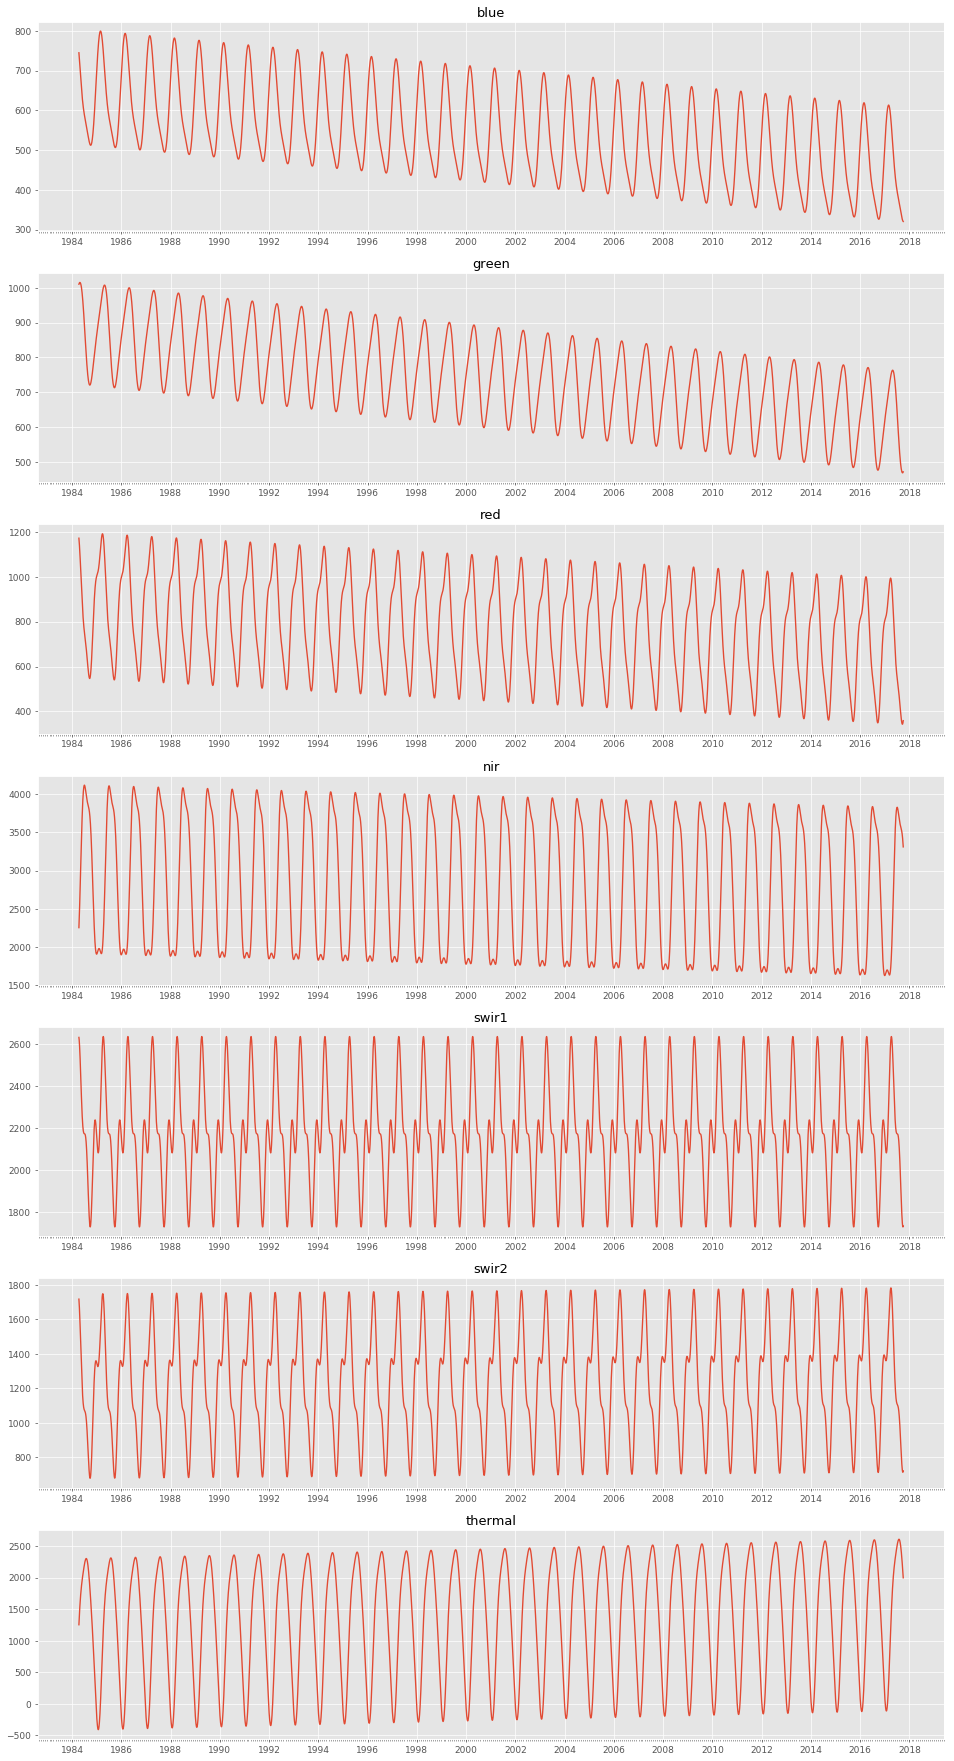

In [33]:
plt.style.use('ggplot')

fig, axes = plt.subplots(nrows=len(bands), ncols=1, figsize=(18, len(bands) * 5),
                         dpi=65, squeeze=False)

years = mdates.YearLocator(base=2)   # every other year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

for ind, b in enumerate(bands):
    axes[ind, 0].plot(days, curves[b], label='model')
    
    axes[ind, 0].set_title(b)
    
    axes[ind, 0].xaxis.set_major_locator(years)
    axes[ind, 0].xaxis.set_major_formatter(yearsFmt)
    axes[ind, 0].xaxis.set_minor_locator(months)
    

__Lets mask the ARD observations using the processing mask.  To do this, the length of both of these sequences must be equal__

In [34]:
assert len(proc_mask) == len(seg_ard[1]['nirs'])

In [35]:
len(seg_ard[1]['nirs'])

1756

In [36]:
# ard_proc = seg_ard[1]['nirs'][np.array(proc_mask, dtype=np.bool)]

ard_proc = {b: seg_ard[1][b+'s'][np.array(proc_mask, dtype=np.bool)] for b in bands}

In [37]:
dates_proc = np.array(
                      [dt.datetime.strptime(c, '%Y-%m-%d').toordinal() for c in chip_dates]
                      )[np.array(proc_mask, dtype=np.bool)]

__Make sure that the length of the masked ARD and dates arrays are equal__

In [38]:
assert len(ard_proc['nir']) == len(dates_proc)

In [39]:
len(ard_proc)

7

## __Plot the Clear ARD Observations Along with the Model Curve__

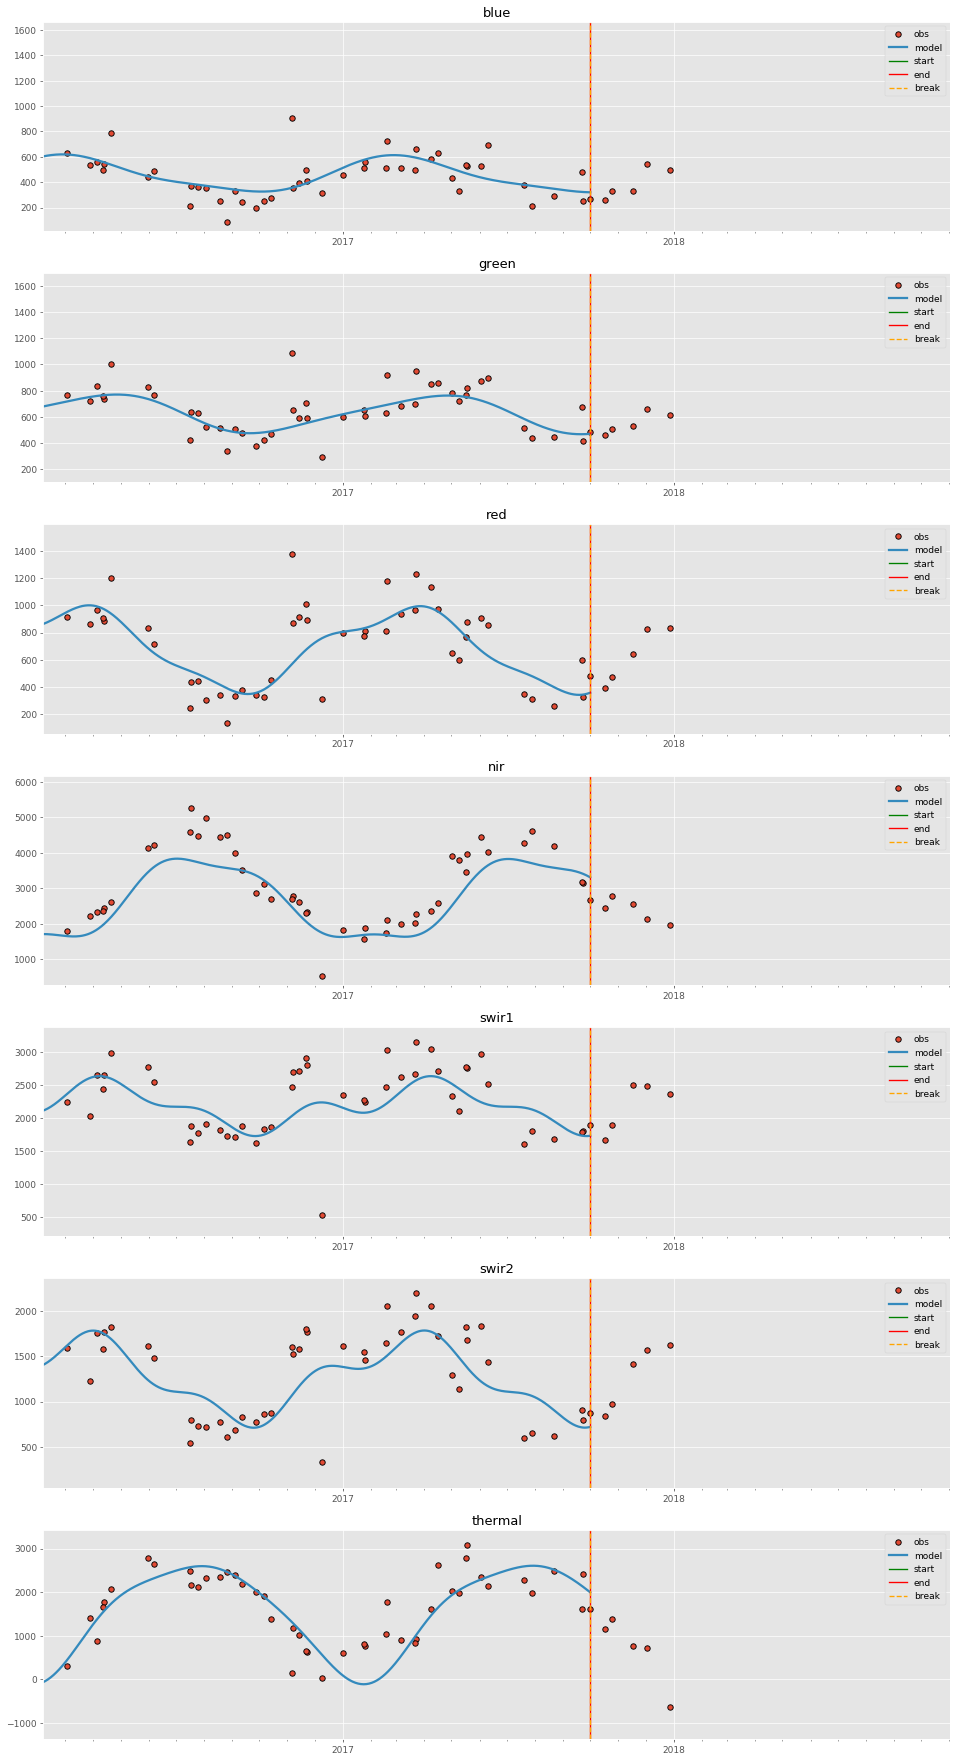

In [40]:
plt.style.use('ggplot')

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

fig, axes = plt.subplots(nrows=len(bands), ncols=1, figsize=(18, len(bands) * 5),
                         dpi=65, squeeze=False)

for num, b in enumerate(bands):
    axes[num, 0].set_title(b)
    
    axes[num, 0].plot(dates_proc, ard_proc[b], linewidth=0, marker='o', mec='k', label='obs')
    
    axes[num, 0].plot(days, curves[b], linewidth=2.5, label='model')
    
    axes[num, 0].axvline(sday, c='g', label='start')
    axes[num, 0].axvline(eday, c='r', label='end')
    axes[num, 0].axvline(bday, c='orange', linestyle='--', label='break')
    
    axes[num, 0].xaxis.set_major_locator(years)
    axes[num, 0].xaxis.set_major_formatter(yearsFmt)
    axes[num, 0].xaxis.set_minor_locator(months)
    
    axes[num, 0].set_xlim(736000, 737000)
    
    axes[num, 0].legend()

__Create a curve extension that goes beyond the model results__

In [60]:
extend_days = np.arange(bday + 1, bday + 366)

In [61]:
extend_curves = {b: predicts(extend_days,
                             segs[0][key_lookup[b]['coefs']],
                             segs[0][key_lookup[b]['inter']])
                for b in bands}

__Request the post-segment ARD observations, we'll need the PIXELQA values this time__

In [62]:
post_acquired = (dt.datetime.fromordinal(extend_days[0]).strftime('%Y-%m-%d'),
                 dt.datetime.fromordinal(extend_days[-1]).strftime('%Y-%m-%d'))

In [63]:
post_cfg = merlin_cfg.make_cfg(['blues', 'greens', 'reds', 'nirs', 'swir1s', 'swir2s', 'thermals', 'qas'], ard_url)
post_cfg

{'grid_fn': functools.partial(<function grid at 0x000001F41AE18488>, url='http://lcmap-test.cr.usgs.gov/ARD_CU_C01_V01', resource='/grid'),
 'dates_fn': <function merlin.dates.symmetric(datemap)>,
 'chips_fn': functools.partial(<function chips at 0x000001F41AE18378>, url='http://lcmap-test.cr.usgs.gov/ARD_CU_C01_V01', resource='/chips'),
 'specs_fn': functools.partial(<function mapped at 0x000001F41AE26B70>, ubids={'blues': ['LC08_SRB2', 'LE07_SRB1', 'LT05_SRB1', 'LT04_SRB1'], 'greens': ['LC08_SRB3', 'LE07_SRB2', 'LT05_SRB2', 'LT04_SRB2'], 'reds': ['LC08_SRB4', 'LE07_SRB3', 'LT05_SRB3', 'LT04_SRB3'], 'nirs': ['LC08_SRB5', 'LE07_SRB4', 'LT05_SRB4', 'LT04_SRB4'], 'swir1s': ['LC08_SRB6', 'LE07_SRB5', 'LT05_SRB5', 'LT04_SRB5'], 'swir2s': ['LC08_SRB7', 'LE07_SRB7', 'LT05_SRB7', 'LT04_SRB7'], 'thermals': ['LC08_BTB10', 'LE07_BTB6', 'LT05_BTB6', 'LT04_BTB6'], 'qas': ['LC08_PIXELQA', 'LE07_PIXELQA', 'LT05_PIXELQA', 'LT04_PIXELQA']}),
 'format_fn': <function merlin.formats.pyccd(x, y, locations

In [64]:
gen = filter(lambda x: x[0][2] == px and x[0][3] == py, 
             merlin.create(x, y, acquired=f'{post_acquired[0]}/{post_acquired[1]}', cfg=post_cfg))

post_seg_ard = next(gen, None)

In [65]:
post_seg_ard[1]['thermals'] = rescale_thermal(post_seg_ard[1]['thermals'])

__Fill values -9999 still need to be removed because we don't have a processing mask for these acquisitions__

In [66]:
fill_mask = post_seg_ard[1]['nirs'] != -9999

In [67]:
fill_mask

array([ True, False, False, False,  True, False,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True, False,
        True])

In [68]:
post_ard = {b: post_seg_ard[1][b+'s'][fill_mask] for b in bands}
post_dates = np.array(post_seg_ard[1]['dates'])[fill_mask]
post_pqa = post_seg_ard[1]['qas'][fill_mask]

__Define a Function to Return only Clear ARD Observations by Using the PIXEL QA Values for Clear Land/Water__

In [69]:
def get_qa_mask(data):
    return np.isin(data, [66, 68, 322, 324])

__Store the QA Mask for Easy Reference__

In [70]:
pqa_mask = get_qa_mask(post_pqa)
pqa_mask

array([ True, False, False,  True, False,  True, False, False, False,
        True, False,  True, False])

In [71]:
post_ard

{'blue': array([ 495, 6617, 4006,  543, 1859,  329, 2200, 2966, 8835,  333, 3151,
         263, 7068], dtype=int16),
 'green': array([ 613, 6565, 4067,  661, 1686,  534, 2148, 2959, 8671,  511, 3432,
         461, 7065], dtype=int16),
 'red': array([ 831, 6539, 4168,  823, 1735,  640, 2139, 3052, 8719,  475, 3556,
         393, 7114], dtype=int16),
 'nir': array([1970, 6662, 4606, 2130, 2413, 2550, 2922, 3963, 8731, 2792, 4669,
        2443, 7414], dtype=int16),
 'swir1': array([2371, 4065, 2761, 2485, 2140, 2509, 1876, 3710, 2610, 1889, 4177,
        1669, 4730], dtype=int16),
 'swir2': array([1623, 4215, 2374, 1568, 1812, 1416, 1611, 3353, 2756,  969, 3322,
         844, 3316], dtype=int16),
 'thermal': array([ -635, -3345, -3185,   725,  -345,   755, -1545,  -225, -2705,
         1375,   985,  1155,   385], dtype=int16)}

In [72]:
post_dates

array([736691, 736675, 736667, 736666, 736659, 736650, 736643, 736635,
       736634, 736627, 736626, 736619, 736611])

## __Plot the Model Results and Obs. along with the Extended Model.__

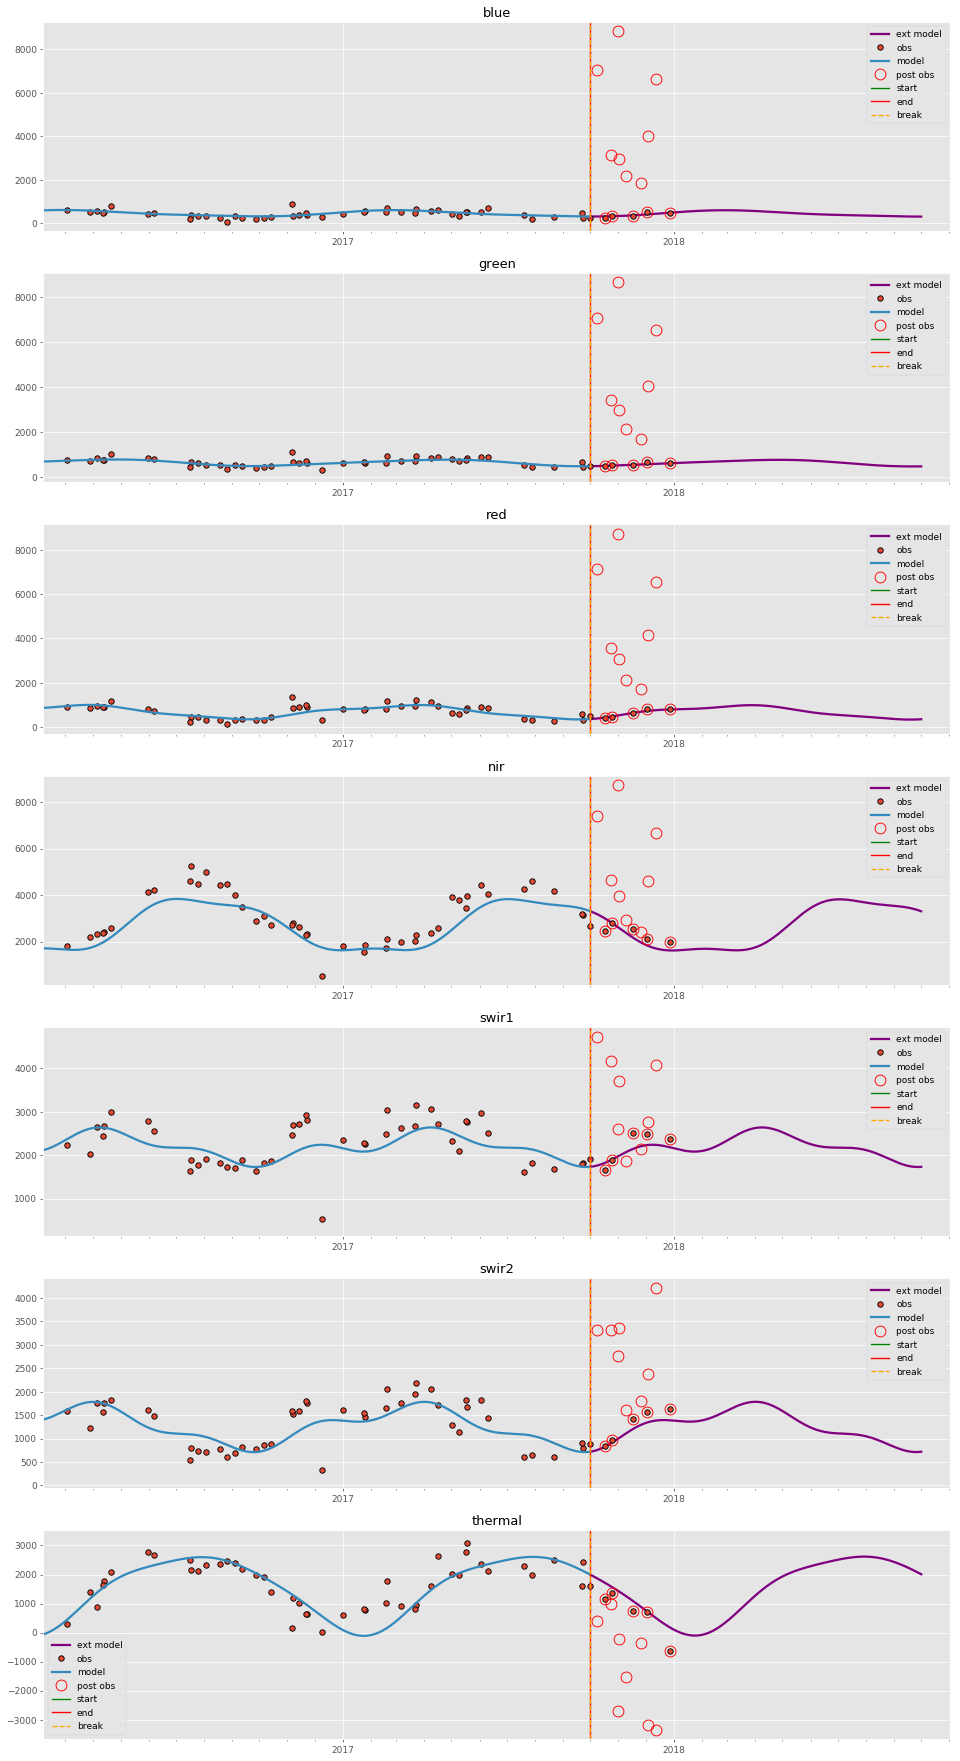

In [75]:
plt.style.use('ggplot')

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

fig, axes = plt.subplots(nrows=len(bands), ncols=1, figsize=(18, len(bands) * 5),
                         dpi=65, squeeze=False)

for num, b in enumerate(bands):
    axes[num, 0].set_title(b)
    
    
    axes[num, 0].plot(extend_days, extend_curves[b], linewidth=2.5, c='purple', label='ext model')
    
    axes[num, 0].plot(dates_proc, ard_proc[b], linewidth=0, marker='o', mec='k', label='obs')
    
    axes[num, 0].plot(days, curves[b], linewidth=2.5, label='model')
    
    axes[num, 0].plot(post_dates, post_ard[b], marker='o', ms=12, linewidth=0, mec='red', c='none', label='post obs')
    
    axes[num, 0].axvline(sday, c='g', label='start')
    axes[num, 0].axvline(eday, c='r', label='end')
    axes[num, 0].axvline(bday, c='orange', linestyle='--', label='break')
    
    axes[num, 0].xaxis.set_major_locator(years)
    axes[num, 0].xaxis.set_major_formatter(yearsFmt)
    axes[num, 0].xaxis.set_minor_locator(months)
    
    axes[num, 0].set_xlim(736000, 737000)
    
    axes[num, 0].legend()

In [55]:
post_acquired

('2017-10-01', '2018-10-01')